### Load Python Package

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from datetime import datetime
from datetime import date
import seaborn as sns
from shapely.geometry import Point, MultiPolygon
import geojson
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
import scipy as sp
from statsmodels.graphics import utils
import statsmodels.stats.api as sms
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.model_selection import KFold
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from statsmodels.stats.outliers_influence import variance_inflation_factor
%matplotlib inline

### Load Training dataet

In [20]:
train = pd.read_csv('./data/transformed_train.csv')
print ("Training data has {} rows and {} columns".format(train.shape[0],train.shape[1]))
print ("data : {}".format(train.shape[0]))
print ("Feature : {}".format(train.shape[1]))

Training data has 701778 rows and 32 columns
data : 701778
Feature : 32


In [21]:
train.drop(['minute','month','day'],axis = 1,inplace = True)

In [22]:
train.shape

(701778, 29)

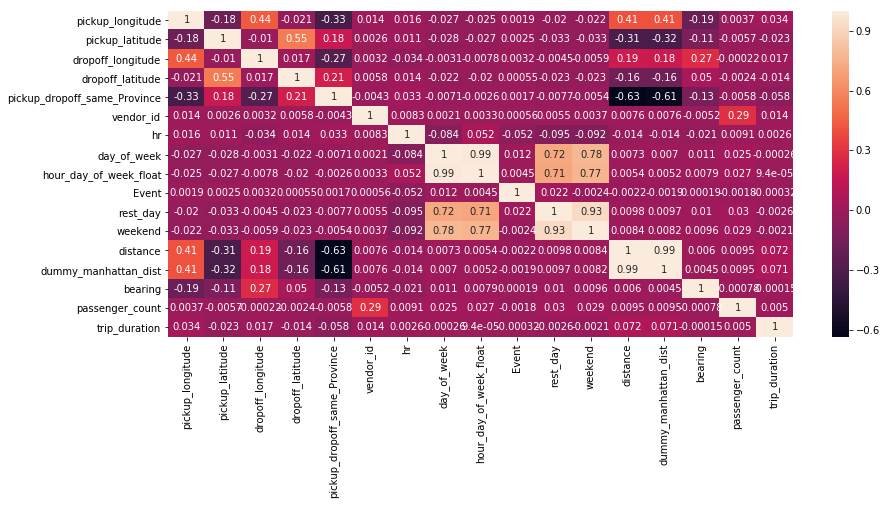

In [23]:
identical = 'id'
depVal = 'trip_duration'
poslist =['pickup_longitude',
          'pickup_latitude',
          'dropoff_longitude',
          'dropoff_latitude']
posCatList = ['pickup_Province','dropoff_Province','pickup_dropoff_same_Province','pickup_Airport','dropoff_Airport']

notUseTimeList = ['pickup_datetime', 'dropoff_datetime', 'pickup_date', 'pickup_time']
notUseSpeedList = ['speed_kmph', 'speed_kmph_dummy']
cateList = ['vendor_id', 'store_and_fwd_flag','hr', 'day_of_week',
       'hour_day_of_week_float', 'Event', 'rest_day', 'weekend']

realList = ['distance','dummy_manhattan_dist', 'bearing', 'passenger_count']
totalCorr = train[poslist+posCatList+cateList+realList+[depVal]].corr()
plt.figure(figsize=(14,6))
sns.heatmap(totalCorr, annot=True)
plt.show()

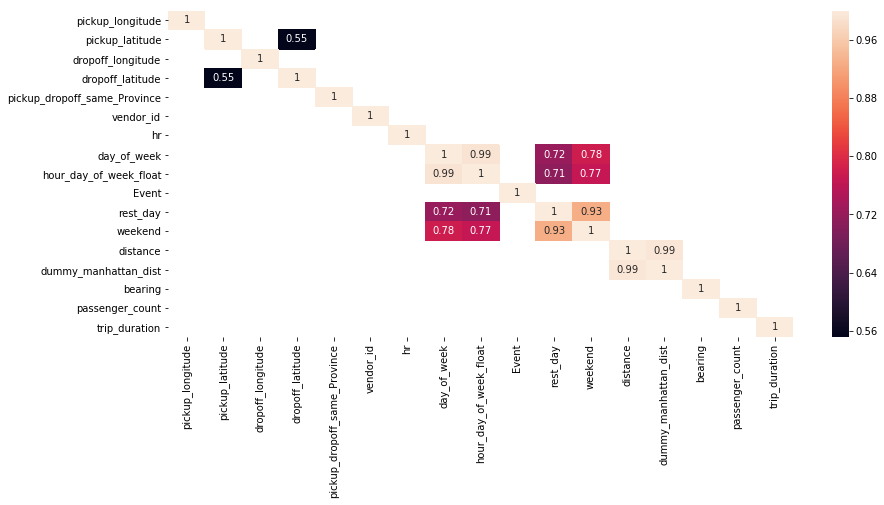

In [24]:
plt.figure(figsize=(14,6))
sns.heatmap(totalCorr[totalCorr>0.5],annot=True)

* 상관계수 > 0.5
> * dropoff_latitude - pickup_latitude
> * day_of_week - rest_day, weekend, hour_day_of_week_float
> * hour_day_of_week_float - rest_day, weekend, day_of_week
> * rest_day : weekend, hour_day_of_week_float, day_of_week
> * **weekend** : rest_day, hour_day_of_week_float, day_of_week
> * distance : dummy_manhattan_dist
> * dummy_manhattan_dist : distance

In [25]:
totalCorr[totalCorr>0.1]

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,pickup_dropoff_same_Province,vendor_id,hr,day_of_week,hour_day_of_week_float,Event,rest_day,weekend,distance,dummy_manhattan_dist,bearing,passenger_count,trip_duration
pickup_longitude,1.000000,NaN,0.438313,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.407602,0.407325,NaN,NaN,NaN
pickup_latitude,NaN,1.000000,NaN,0.552018,0.176025,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
dropoff_longitude,0.438313,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.186463,0.181178,0.271311,NaN,NaN
dropoff_latitude,NaN,0.552018,NaN,1.000000,0.214353,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
pickup_dropoff_same_Province,NaN,0.176025,NaN,0.214353,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
vendor_id,NaN,NaN,NaN,NaN,NaN,1.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.29047,NaN
hr,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
day_of_week,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,0.990658,NaN,0.723026,0.778697,NaN,NaN,NaN,NaN,NaN
hour_day_of_week_float,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.990658,1.000000,NaN,0.711598,0.767745,NaN,NaN,NaN,NaN,NaN
Event,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [26]:
#posCatList=list(map(lambda x: 'C({})'.format(x), posCatList))
#cateList = list(map(lambda x: 'C({})'.format(x),cateList))

In [ ]:
#1
#formulaIs ='I(np.log(trip_duration)) ~ I(np.log(dummy_manhattan_dist+0.1))+I(np.log(distance+0.1))+scale(bearing) +passenger_count+C(pickup_Province)+(dropoff_Province) +C(hr):C(rest_day)+0'
#fList = ['dummy_manhattan_dist','distance','bearing','dropoff_Province','pickup_Province','hr','rest_day']

#2
#formulaIs ='I(np.log(trip_duration)) ~ I(np.log(dummy_manhattan_dist+0.1))+I(np.log(distance+0.1))+scale(bearing)+C(pickup_Province)*C(dropoff_Province) +C(hr)*C(rest_day) + 0'
#fList = ['dummy_manhattan_dist','distance','bearing','dropoff_Airport','dropoff_Province','pickup_Airport','pickup_Province','hr','rest_day']

#3
#formulaIs ='I(np.log(trip_duration)) ~ I(np.log(dummy_manhattan_dist+0.1))+I(np.log(distance+0.1))+scale(bearing) + C(pickup_dropoff_same_Province)+C(hr):C(day_of_week)+0'
#fList = ['dummy_manhattan_dist','distance','bearing','pickup_dropoff_same_Province','hr','day_of_week']

#4
#formulaIs ='I(np.log(trip_duration)) ~ I(np.log(dummy_manhattan_dist+0.1))+I(np.log(distance+0.1))+scale(bearing) + C(pickup_dropoff_same_Province)+C(hour_day_of_week_float)+0'
#fList = ['dummy_manhattan_dist','distance','bearing','pickup_dropoff_same_Province','hour_day_of_week_float']

#5
#formulaIs ='np.log(trip_duration) ~ I(np.log(dummy_manhattan_dist+0.1))+I(np.log(distance+0.1))+scale(bearing) +C(pickup_Province):C(dropoff_Airport)+C(pickup_Airport):C(dropoff_Province) + C(pickup_dropoff_same_Province)+C(hr):C(day_of_week)+0'
#fList = ['dummy_manhattan_dist','distance','pickup_Province','dropoff_Airport','pickup_Province','dropoff_Airport','bearing','pickup_dropoff_same_Province','hr','day_of_week']

#6
#formulaIs ='np.log(trip_duration) ~ I(np.log(dummy_manhattan_dist+0.1))+I(np.log(distance+0.1))+scale(bearing) +C(pickup_Province):C(dropoff_Airport)+C(pickup_Airport):C(dropoff_Province) + C(hr):C(day_of_week)+0'
#fList = ['dummy_manhattan_dist','distance','pickup_Province','dropoff_Airport','pickup_Province','dropoff_Airport','bearing','hr','day_of_week']

#7
formulaIs ='I(np.log(trip_duration)) ~ scale(pickup_longitude)+scale(pickup_latitude)+scale(dropoff_longitude)+scale(dropoff_latitude)+ C(pickup_dropoff_same_Province)+C(hr):C(day_of_week)+0'
fList = ['pickup_dropoff_same_Province','hr','day_of_week','pickup_longitude',    'pickup_latitude',    'dropoff_longitude',       'dropoff_latitude']

#formulaIs ='np.log(trip_duration) ~ scale(I(np.log(dummy_manhattan_dist+0.1)))+scale(I(np.log(distance+0.1)))+bearing +C(pickup_Province)+C(dropoff_Province) + C(pickup_dropoff_same_Province)+C(hr)*C(day_of_week)+0'

#formulaIs ='np.log(trip_duration) ~ scale(I(np.log(dummy_manhattan_dist+0.1)))+scale(I(np.log(distance+0.1)))+bearing +C(pickup_Province)+C(dropoff_Province) + +C(hr)*C(day_of_week)+0'
#fList = ['dummy_manhattan_dist','distance','bearing','pickup_dropoff_same_Province','hour_day_of_week_float']
#fList = ['dummy_manhattan_dist','distance','bearing','pickup_dropoff_same_Province','hr','day_of_week']
model = sm.OLS.from_formula(formulaIs,data = train)
result = model.fit()
result.summary()

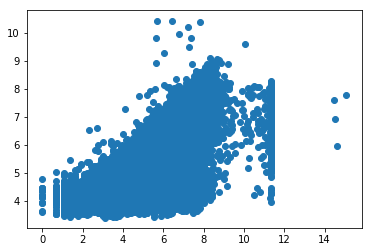

In [28]:
y_new = result.predict(train[fList])
y = train.apply(lambda x:np.log(x.trip_duration),axis=1)
plt.scatter(y,y_new)

In [29]:
inf = result.get_influence()
hat = inf.hat_matrix_diag
print('hat.sum() =',hat.sum())
x_new = train[fList]
y_new = result.predict()

hat.sum() = 62.0


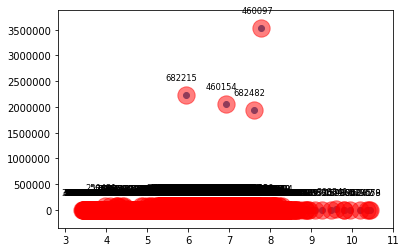

21609

In [30]:
cooks_d2, pvals = inf.cooks_distance
fox_cr = 4 / (len(train['trip_duration']) - 2)
idx = np.where(cooks_d2 > fox_cr)[0]

ax = plt.subplot()
plt.scatter(y_new,train['trip_duration'])
plt.scatter(y_new[idx], train['trip_duration'][idx], s=300, c="r", alpha=0.5)
utils.annotate_axes(range(len(idx)), idx, 
                    list(zip(y_new[idx], train['trip_duration'][idx])), [(-20, 15)] * len(idx), size="small", ax=ax)
plt.show()
len(idx)

In [31]:
sm.stats.anova_lm(result,typ =2)

,sum_sq,df,F,PR(>F)
C(pickup_Province),94555.691511,6.0,70403.213420,0.000000e+00
dropoff_Province,552.142057,5.0,493.329268,0.000000e+00
C(hr):C(rest_day),18905.075157,47.0,1796.952543,0.000000e+00
I(np.log(dummy_manhattan_dist + 0.1)),1853.117785,1.0,8278.641600,0.000000e+00
I(np.log(distance + 0.1)),9375.130077,1.0,41882.573525,0.000000e+00
scale(bearing),547.721746,1.0,2446.898987,0.000000e+00
passenger_count,65.869272,1.0,294.265210,6.035508e-66
Residual,157074.368249,701716.0,NaN,NaN


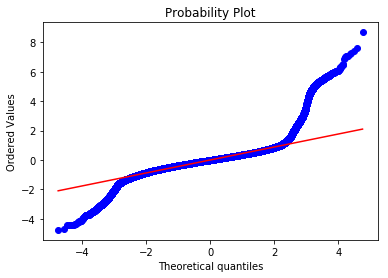

In [32]:
sp.stats.probplot(result.resid, plot=plt)
plt.show()

In [33]:
cv = KFold(n_splits=4, shuffle=True, random_state=0)

0.645371893067
0.647819910476
0.646916297346
0.645869724089


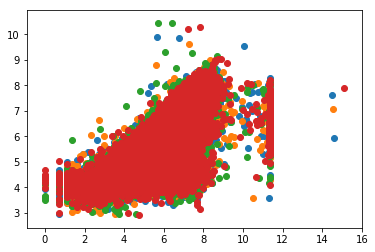

In [34]:
formulaIs ='I(np.log(trip_duration)) ~ I(np.log(dummy_manhattan_dist+0.1))+I(np.log(distance+0.1))+bearing +C(pickup_Province)*C(dropoff_Airport)+C(pickup_Airport)*C(dropoff_Province) + C(pickup_dropoff_same_Province)+C(hr)*C(day_of_week)+ 0'
fList = ['dummy_manhattan_dist','distance','bearing','dropoff_Airport','dropoff_Province','pickup_Airport','pickup_Province','pickup_dropoff_same_Province','hr','day_of_week','pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude']

#formulaIs ='I(np.log(trip_duration)) ~ I(np.log(dummy_manhattan_dist+0.1))+bearing +C(dropoff_Province)*C(pickup_Province)+C(hr)*C(day_of_week) + pickup_longitude+pickup_latitude+dropoff_longitude+dropoff_latitude + 0'
#fList = ['dummy_manhattan_dist','bearing','dropoff_Province','pickup_Province','hr','day_of_week','pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude']

for train_index, test_index in cv.split(train):
    cTrainDe = train.loc[train_index][fList+['trip_duration']]
    #cTrainIn = train.loc[train_index]
    modelc = sm.OLS.from_formula(formulaIs,cTrainDe)
    resultc = modelc.fit()
    x = resultc.rsquared
    print (x)
    cTest = train.loc[test_index][fList]
    #cTestOut = train.loc[test_index]['trip_duration']    
    y_new = resultc.predict(cTest[fList])
    y = train.loc[test_index].apply(lambda x:np.log(x.trip_duration),axis=1)
    #y = train.loc[train_index]['trip_duration']
    plt.scatter(y,y_new)

In [35]:
xTrain = model.fit_regularized(alpha=0.01,L1_wt=1)

In [36]:
xTrain.params

C(pickup_Province)[Bronx]                0.000000
C(pickup_Province)[Brooklyn]             4.962058
C(pickup_Province)[Manhattan]            5.618173
C(pickup_Province)[Queens]               5.303970
C(pickup_Province)[Staten Island]        0.000000
C(pickup_Province)[outward]              0.000000
dropoff_Province[T.Brooklyn]             0.000000
dropoff_Province[T.Manhattan]            0.000000
dropoff_Province[T.Queens]               0.000000
dropoff_Province[T.Staten Island]        0.000000
dropoff_Province[T.outward]              0.000000
C(rest_day)[T.True]                      0.000000
C(hr)[T.1]:C(rest_day)[False]            0.000000
C(hr)[T.2]:C(rest_day)[False]            0.000000
C(hr)[T.3]:C(rest_day)[False]            0.000000
C(hr)[T.4]:C(rest_day)[False]            0.000000
C(hr)[T.5]:C(rest_day)[False]            0.000000
C(hr)[T.6]:C(rest_day)[False]            0.000000
C(hr)[T.7]:C(rest_day)[False]            0.000000
C(hr)[T.8]:C(rest_day)[False]            0.000000


In [37]:
filter_X =train[:]
filter_X.drop(idx,0,inplace = True)

filter_X.tail()
print (train.shape)
print (filter_X.shape)

(701778, 29)
(680169, 29)


C:\Users\pc\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [38]:
modela = sm.OLS.from_formula(formulaIs,data = filter_X)
resulta = modela.fit()
resulta.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               OLS Regression Results                               
====================================================================================
Dep. Variable:     I(np.log(trip_duration))   R-squared:                       0.746
Model:                                  OLS   Adj. R-squared:                  0.746
Method:                       Least Squares   F-statistic:                     9847.
Date:                      Tue, 24 Oct 2017   Prob (F-statistic):               0.00
Time:                              02:36:17   Log-Likelihood:            -2.6609e+05
No. Observations:                    680169   AIC:                         5.326e+05
Df Residuals:                        679965   BIC:                         5.349e+05
Df Model:                               203                                         
Covariance Type:                  nonrobust                                         
===============================================================================================================================
                                                                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------------------------
C(pickup_Province)[Bronx]                                       5.0772      0.359     14.139      0.000       4.373       5.781
C(pickup_Province)[Brooklyn]                                    5.0254      0.056     89.176      0.000       4.915       5.136
C(pickup_Province)[Manhattan]                                   5.0090      0.030    166.795      0.000       4.950       5.068
C(pickup_Province)[Queens]                                      5.0068      0.036    137.773      0.000       4.936       5.078
C(pickup_Province)[Staten Island]                               3.4233      0.255     13.411      0.000       2.923       3.924
C(pickup_Province)[outward]                                     5.0164      0.359     13.970      0.000       4.313       5.720
C(dropoff_Airport)[T.L]                                         0.1656      0.413      0.401      0.689      -0.644       0.976
C(dropoff_Airport)[T.N]                                         0.3065      0.359      0.854      0.393      -0.397       1.010
C(pickup_Airport)[T.L]                                          0.1705      0.035      4.879      0.000       0.102       0.239
C(pickup_Airport)[T.N]                                          0.0893      0.028      3.139      0.002       0.034       0.145
C(dropoff_Province)[T.Brooklyn]                                 0.2642      0.029      9.155      0.000       0.208       0.321
C(dropoff_Province)[T.Manhattan]                                0.2658      0.028      9.483      0.000       0.211       0.321
C(dropoff_Province)[T.Queens]                                   0.1756      0.029      6.042      0.000       0.119       0.233
C(dropoff_Province)[T.Staten Island]                            0.2154      0.208      1.033      0.302      -0.193       0.624
C(dropoff_Province)[T.outward]                                  0.0843      0.041      2.044      0.041       0.003       0.165
C(pickup_dropoff_same_Province)[T.1]                           -0.0312      0.003    -10.713      0.000      -0.037      -0.025
C(hr)[T.1]                                                     -0.0202      0.014     -1.488      0.137      -0.047       0.006
C(hr)[T.2]                                                     -0.0259      0.016     -1.583      0.113      -0.058       0.006
C(hr)[T.3]                                                     -0.0117      0.019     -0.617      0.537      -0.049       0.025
C(hr)[T.4]                                                     -0.0672      0.018     -3.775      0.000      -0.102      -0.032
C(hr)[T.5]                                                     -0.0781   

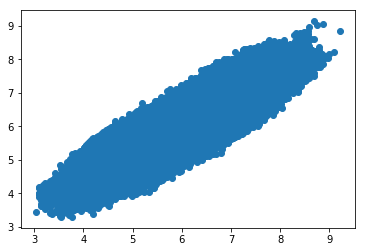

In [39]:
y_newa = resulta.predict(filter_X[fList])
ya = filter_X.apply(lambda x:np.log(x.trip_duration),axis=1)
plt.scatter(ya,y_newa)

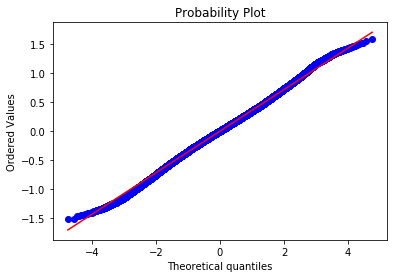

In [40]:
sp.stats.probplot(resulta.resid, plot=plt)
plt.show()

In [41]:
filter_X = filter_X[:][ (filter_X['passenger_count']!=0) 
                       & (filter_X['dummy_manhattan_dist']!=0) 
                       & (filter_X['distance']!=0) 
                       & (filter_X['speed_kmph_dummy']<100)]

In [42]:
modelb = sm.OLS.from_formula(formulaIs,data = filter_X)
resultb = modelb.fit()
resultb.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               OLS Regression Results                               
====================================================================================
Dep. Variable:     I(np.log(trip_duration))   R-squared:                       0.745
Model:                                  OLS   Adj. R-squared:                  0.745
Method:                       Least Squares   F-statistic:                     9837.
Date:                      Tue, 24 Oct 2017   Prob (F-statistic):               0.00
Time:                              02:37:58   Log-Likelihood:            -2.6560e+05
No. Observations:                    679802   AIC:                         5.316e+05
Df Residuals:                        679599   BIC:                         5.339e+05
Df Model:                               202                                         
Covariance Type:                  nonrobust                                         
===============================================================================================================================
                                                                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------------------------
C(pickup_Province)[Bronx]                                       5.0740      0.359     14.138      0.000       4.371       5.777
C(pickup_Province)[Brooklyn]                                    5.0224      0.056     89.167      0.000       4.912       5.133
C(pickup_Province)[Manhattan]                                   5.0056      0.030    166.750      0.000       4.947       5.064
C(pickup_Province)[Queens]                                      4.9972      0.036    137.121      0.000       4.926       5.069
C(pickup_Province)[outward]                                     5.0132      0.359     13.968      0.000       4.310       5.717
C(dropoff_Airport)[T.L]                                         0.1661      0.413      0.402      0.688      -0.644       0.976
C(dropoff_Airport)[T.N]                                         0.3030      0.359      0.845      0.398      -0.400       1.006
C(pickup_Airport)[T.L]                                          0.1713      0.035      4.904      0.000       0.103       0.240
C(pickup_Airport)[T.N]                                          0.0894      0.028      3.143      0.002       0.034       0.145
C(dropoff_Province)[T.Brooklyn]                                 0.2646      0.029      9.176      0.000       0.208       0.321
C(dropoff_Province)[T.Manhattan]                                0.2657      0.028      9.486      0.000       0.211       0.321
C(dropoff_Province)[T.Queens]                                   0.1748      0.029      6.015      0.000       0.118       0.232
C(dropoff_Province)[T.Staten Island]                            0.2155      0.208      1.034      0.301      -0.193       0.624
C(dropoff_Province)[T.outward]                                  0.0845      0.041      2.051      0.040       0.004       0.165
C(pickup_dropoff_same_Province)[T.1]                           -0.0304      0.003    -10.436      0.000      -0.036      -0.025
C(hr)[T.1]                                                     -0.0199      0.014     -1.466      0.143      -0.047       0.007
C(hr)[T.2]                                                     -0.0261      0.016     -1.596      0.110      -0.058       0.006
C(hr)[T.3]                                                     -0.0119      0.019     -0.627      0.531      -0.049       0.025
C(hr)[T.4]                                                     -0.0677      0.018     -3.800      0.000      -0.103      -0.033
C(hr)[T.5]                                                     -0.0782      0.015     -5.385      0.000      -0.107      -0.050
C(hr)[T.6]                                                      0.0135   

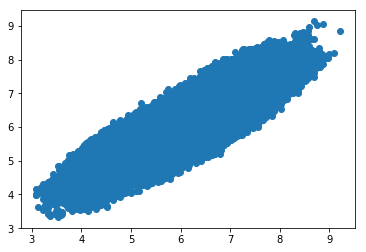

In [43]:
y_newb = resultb.predict(filter_X[fList])
yb = filter_X.apply(lambda x:np.log(x.trip_duration),axis=1)
plt.scatter(yb,y_newb)

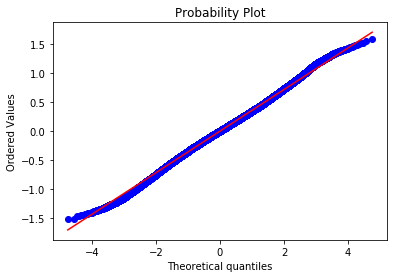

In [44]:
sp.stats.probplot(resultb.resid, plot=plt)
plt.show()

#### Dependent Variable
> * trip_duration
>  * 100000(sec) 이상의 값을 보이는 데이터가 4개 존재함

In [45]:
test = pd.read_csv('./data/test.csv')
print ("Training data has {} rows and {} columns".format(test.shape[0],test.shape[1]))
print ("data : {}".format(test.shape[0]))
print ("Feature : {}".format(test.shape[1]))

Training data has 346797 rows and 9 columns
data : 346797
Feature : 9


In [46]:
test['pickup_datetime'] = pd.to_datetime(test['pickup_datetime'])

In [47]:
test['hr'] = test['pickup_datetime'].dt.hour

In [48]:
test['year']=test['pickup_datetime'].dt.year

In [49]:
test['month'] = test['pickup_datetime'].dt.month

In [50]:
test['day_of_week'] = test['pickup_datetime'].dt.dayofweek

In [55]:
test['day'] = test['pickup_datetime'].dt.day

In [56]:
def restday(yr,month,day,holidays):
    '''
    Output:
        is_rest: a list of Boolean variable indicating if the sample occurred in the rest day.
        is_weekend: a list of Boolean variable indicating if the sample occurred in the weekend.
    '''
    is_rest    = [None]*len(yr)
    is_weekend = [None]*len(yr)
    i=0
    for yy,mm,dd in zip(yr,month,day):        
        is_weekend[i] = date(yy,mm,dd).isoweekday() in (6,7)
        is_rest[i]    = is_weekend[i] or date(yy,mm,dd) in holidays 
        i+=1
    return is_rest,is_weekend

In [57]:
holiday = pd.read_csv('./data/NYC_2016Holidays.csv',sep=';')
holiday['Date'] = holiday['Date'].apply(lambda x: x + ' 2016')
holidays = [datetime.strptime(holiday.loc[i,'Date'], '%B %d %Y').date() for i in range(len(holiday))]

In [61]:
rest_day,weekend = restday(test.year,test.month,test.day,holidays)
timeTest = pd.DataFrame(index = range(len(test)))
timeTest = timeTest.assign(rest_day=rest_day)
timeTest = timeTest.assign(weekend=weekend)

In [62]:
with open('./data/BoroughBoundaries.geojson') as f:
    data = geojson.load(f)
das = dict()
for feature in data['features']:
    boro_name = feature['properties']['boro_name']
    shape_leng = feature['properties']['shape_leng']
    shape_area = feature['properties']['shape_area']
    coords = feature['geometry']['coordinates']
    binList = []
    print (boro_name, shape_area)
    for i in coords:
        for j in i:
            binList.append([j,[]])
    das[boro_name] = MultiPolygon(binList)

Staten Island 1623914222.74
Bronx 1186678192.09
Queens 3044779902.31
Brooklyn 1937477754.43
Manhattan 636479884.362


In [63]:
def CheckProvince(daf, long1, lati1):
    gpsPointIs = Point(long1,lati1)
    provinceIs = ','.join(list(filter(lambda x: daf[x].contains(gpsPointIs), daf.keys())))
    if provinceIs =='':
        provinceIs = 'outward'
    return provinceIs

In [64]:
test['pickup_Province'] =test.apply(lambda x: CheckProvince(das, x.pickup_longitude, x.pickup_latitude), axis =1)

In [65]:
test['dropoff_Province'] = test.apply(lambda x: CheckProvince(das, x.dropoff_longitude, x.dropoff_latitude), axis =1)

In [68]:
test.to_csv('./data/transformed_test.csv',index = False)

In [67]:
def SameProvince(x):
    if x['pickup_Province']==x['dropoff_Province']:
        return 1
    else:
        return 0
test['pickup_dropoff_same_Province']= test.apply(lambda x:SameProvince(x),axis = 1)

In [69]:
with open('./data/Airport Point.geojson') as f:
    datas = geojson.load(f)
dot = dict()
for x in range(len(datas['features'])):
    name = datas['features'][x]['properties']['name']
    coords = datas['features'][x]['geometry']['coordinates']
    dot[name[0]] = coords

In [70]:
def dummy_manhattan_distance(lat1, lng1, lat2, lng2):
    a = haversine_array(lat1, lng1, lat1, lng2)
    b = haversine_array(lat1, lng1, lat2, lng1)
    return a + b

In [71]:
def haversine_array(latitude1, longitude1, latitude2, longitude2):
    latitude1, longitude1, latitude2, longitude2 = map(np.radians, (latitude1, longitude1, latitude2, longitude2))
    # The average radius of the earth
    # in km
    AVG_EARTH_RADIUS = 6371
    lat = latitude2 - latitude1
    lng = longitude2 - longitude1
    d = np.sin(lat * 0.5) ** 2 + np.cos(latitude1) * np.cos(latitude2) * np.sin(lng * 0.5) ** 2
    h = 2 * AVG_EARTH_RADIUS * np.arcsin(np.sqrt(d))
    return h

In [72]:
def CheckAirport(df, long, lati, province, f):
    if province == f:
        filterIs = list(filter(lambda x: haversine_array(long,lati,df[x][0],df[x][1]) < 1.5, df))
        if not filterIs:
            out = 'N'
        else:
            out = filterIs[0]
    else:
        out ='N'
    return out

In [73]:
test['pickup_Airport'] = test.apply(lambda x: CheckAirport(dot, x.pickup_longitude, x.pickup_latitude, x.pickup_Province, 'Queens'), axis = 1)

In [74]:
test['dropoff_Airport'] = test.apply(lambda x: CheckAirport(dot, x.dropoff_longitude, x.dropoff_latitude, x.dropoff_Province, 'Queens'), axis = 1)

In [75]:
def bearing_array(lat1, lng1, lat2, lng2):
    AVG_EARTH_RADIUS = 6371  # in km
    lng_delta_rad = np.radians(lng2 - lng1)
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    y = np.sin(lng_delta_rad) * np.cos(lat2)
    x = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(lng_delta_rad)
    return np.degrees(np.arctan2(y, x))

In [76]:
test['distance'] = test.apply(lambda x:haversine_array(x.pickup_latitude, x.pickup_longitude, x.dropoff_latitude, x.dropoff_longitude), axis =1 )

In [77]:
test['dummy_manhattan_dist'] = test.apply(lambda x:dummy_manhattan_distance(x.pickup_latitude, x.pickup_longitude, x.dropoff_latitude, x.dropoff_longitude), axis =1 )

In [78]:
test['bearing'] = test.apply(lambda x:bearing_array(x.pickup_latitude, x.pickup_longitude, x.dropoff_latitude, x.dropoff_longitude), axis =1 )

In [79]:
print (test.shape)
print (test['pickup_Province'].value_counts())
print (test['dropoff_Province'].value_counts())
print (test['pickup_Airport'].value_counts())
print (test['dropoff_Airport'].value_counts())

(346797, 22)
Manhattan        317848
Queens            21578
Brooklyn           6723
Bronx               324
outward             309
Staten Island        15
Name: pickup_Province, dtype: int64
Manhattan        304812
Queens            19047
Brooklyn          18806
Bronx              2358
outward            1665
Staten Island       109
Name: dropoff_Province, dtype: int64
N    332734
L      9428
J      4635
Name: pickup_Airport, dtype: int64
N    340257
L      4752
J      1788
Name: dropoff_Airport, dtype: int64


In [80]:
test.to_csv('./data/transformed_test.csv',index=False)

In [81]:
test = pd.read_csv('./data/transformed_test.csv')
print ("Training data has {} rows and {} columns".format(test.shape[0],test.shape[1]))
print ("data : {}".format(test.shape[0]))
print ("Feature : {}".format(test.shape[1]))

Training data has 346797 rows and 22 columns
data : 346797
Feature : 22


In [26]:
testy = resultb.predict(test[fList])

In [27]:
tx = pd.concat([test['id'],testy],axis=1)

In [28]:
tx

,id,0
0,id2332349,6.892749
1,id2013516,6.185159
2,id3719493,7.842722
3,id0376262,7.300766
4,id2105228,6.387913
5,id1276841,6.339212
6,id3016059,6.291779
7,id3952659,6.512010
8,id1255468,6.130016
9,id3049611,5.763472
